# 1. Introdução

Objetivo: O objetivo deste projeto é montar um banco de dados SQL na plataforma
Google Cloud Platform (GCP), consumir essa base no Google Colab e transformá-la
em DataFrames para análise de dados. O tratamento dos dados será realizado 
conforme necessário, e técnicas estatísticas serão aplicadas para suportar
decisões informadas.

# 2. Arquitetura

Este projeto consiste em três partes principais:

    1. Montvalor_aluguelm do banco de dados no GCP.
    2. Consumo da base no Google Colab e transformação em DataFrames.
    3. Tratamento de dados e análise estatística.

# 3. Passos para Montar o Banco de Dados no GCP

## 3.1. Criação do Banco de Dados SQL no GCP

1. Acesse o Google Cloud Console.
2. Navegue até a seção Cloud SQL e crie uma nova instância.
3. Escolha a versão do banco de dados (MySQL, PostgreSQL, etc.).
4. Importe a base de dados SQL fornecida, utilizando o comando de importação disponível no console ou por meio de gcloud

   ```bash
    gcloud auth login --no-launch-browser
    gcloud sql import sql mysql-soulcode gs://soulcode-analytics-data-bootcamp/projeto_logistica.sql
    ```
   

In [89]:
import os
import io
import math
import numpy as np
import pandas as pd
import mysql.connector
from mysql.connector import Error
from google.cloud import storage
from pyspark.sql import DataFrame, SparkSession
from unidecode import unidecode

from scipy import stats

from sqlalchemy import Column, Integer, Float, String, Boolean, DateTime, Text
from sqlalchemy.orm import declarative_base

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# credentials_path = "/home/jovyan/code/.devcontainer/soulcode-iam-key.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path

# 5. Consumindo o Banco de Dados no Google Colab

# 5.1. Database Locadora

### 5.1.1 Configuração do Ambiente

1. Configure a conexão com o banco de dados no GCP

In [3]:
HOST = '34.16.33.165'
DB = 'locadora'
USER = 'soulcode'
PASSWORD = 'Soulcode@!12pass'

In [4]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus

engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB}')
connection = engine.connect()

## 5.1.2 Transformação em DataFrames Pandas

In [5]:
query = """SELECT
    a.codaluguel AS codigo_aluguel,
    a.data_aluguel AS data_aluguel,
    c.nome AS nome_cliente,
    c.cidade AS cidade_cliente,
    c.sexo AS sexo_cliente,
    c.estado AS estado_cliente,
    c.estadocivil AS estadocivil_cliente,
    car.modelo AS modelo_carro,
    car.valor AS valor_aluguel,
    m.marca AS marca_carro
FROM
    aluguel a
INNER JOIN cliente c ON a.codcliente = c.codcliente
INNER JOIN carro car ON a.codcarro = car.codcarro
INNER JOIN marca m ON car.codmarca = m.codmarca;"""

df = pd.read_sql(query, connection)
df

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen


## 5.1.3. Tratamento de Dados

**Analisando o dataset**

Dimensão do dataset:

In [20]:
df.shape

(10, 10)

Verificação de dados faltantes:

In [22]:
df.isnull().sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Verficando informações sobre sobre dataframe incluindo index, tipo dos dados e
colunas não nulas e uso da memoria

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo_aluguel       10 non-null     int64  
 1   data_aluguel         10 non-null     object 
 2   nome_cliente         10 non-null     object 
 3   cidade_cliente       10 non-null     object 
 4   sexo_cliente         10 non-null     object 
 5   estado_cliente       10 non-null     object 
 6   estadocivil_cliente  10 non-null     object 
 7   modelo_carro         10 non-null     object 
 8   valor_aluguel        10 non-null     float64
 9   marca_carro          10 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 932.0+ bytes


Analisando o dataframe, para identificar o tipo que corresponde aos dados

In [46]:
df.head()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro,ano_aluguel,mes_aluguel,dia_aluguel
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,2
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,3
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford,2023,4,15
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford,2023,4,25
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat,2023,4,1


In [45]:
df.tail()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro,ano_aluguel,mes_aluguel,dia_aluguel
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,19
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,21
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet,2023,4,4
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,5
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,13


Verificando colunas numéricas com valores zerados

In [27]:
df.eq(0).sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Remover registro duplicados

Deletar registro duplicados

In [36]:
df = df.drop_duplicates()

 Conversão de Tipos de Dados

In [40]:
df['data_aluguel'] = pd.to_datetime(df['data_aluguel'], errors='coerce')
df['ano_aluguel'] = df['data_aluguel'].dt.year
df['mes_aluguel'] = df['data_aluguel'].dt.month
df['dia_aluguel'] = df['data_aluguel'].dt.day


## 5.1.4. Análise Estatística Descritiva

In [52]:
df.describe()

,codigo_aluguel,data_aluguel,valor_aluguel,ano_aluguel,mes_aluguel,dia_aluguel
count,10.00000,10,10.000000,10.0,10.0,10.000000
mean,5.50000,2023-04-10 19:12:00,132.000000,2023.0,4.0,10.800000
min,1.00000,2023-04-01 00:00:00,100.000000,2023.0,4.0,1.000000
25%,3.25000,2023-04-03 06:00:00,100.000000,2023.0,4.0,3.250000
50%,5.50000,2023-04-09 00:00:00,150.000000,2023.0,4.0,9.000000
75%,7.75000,2023-04-18 00:00:00,150.000000,2023.0,4.0,18.000000
max,10.00000,2023-04-25 00:00:00,170.000000,2023.0,4.0,25.000000
std,3.02765,NaN,28.205594,0.0,0.0,8.879439


In [59]:
# Matriz de correlação #TODO:estudar
# correlacao = df[['valor_aluguel', 'dia_aluguel']].corr()  # ou 'spearman' para correlação não linear
# correlacao

,valor_aluguel,dia_aluguel
valor_aluguel,1.000000,-0.100264
dia_aluguel,-0.100264,1.000000


Boxplot e Identificação de Outliers

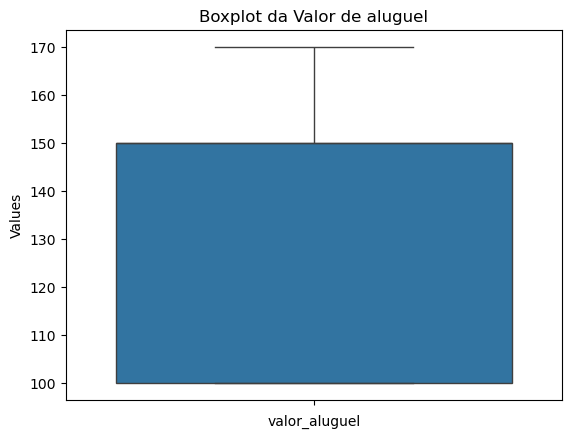

In [68]:
sns.boxplot(y='valor_aluguel', data=df)
plt.title('Boxplot da Valor de aluguel')
plt.xlabel('valor_aluguel')
plt.ylabel('Values')
plt.show()

Z-Score: Identifica outliers com base em quantos desvios padrão uma observação está distante da média

In [77]:
# z_scores = stats.zscore(df.select_dtypes(include=[float, int])) 
z_scores = stats.zscore(df['valor_aluguel'])
z_scores

0   -1.195896
1   -1.195896
2   -1.195896
3   -1.195896
4    0.672692
5    0.672692
6    0.672692
7    1.420127
8    0.672692
9    0.672692
Name: valor_aluguel, dtype: float64

In [80]:
outliers = df['valor_aluguel'][(z_scores > 3)]
outliers

Series([], Name: valor_aluguel, dtype: float64)

Histrograma para Frequência

In [84]:
n = len(df)
n

10

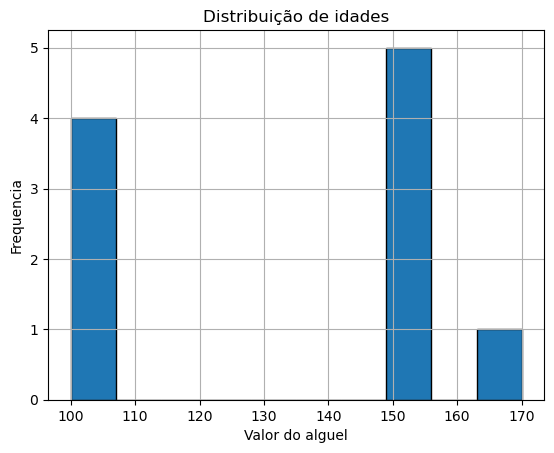

In [93]:
 
df['valor_aluguel'].hist(edgecolor='black')
plt.title('Distribuição de idades')
plt.xlabel('Valor do alguel')
plt.ylabel('Frequencia')
plt.show()


In [94]:
df.columns

Index(['codigo_aluguel', 'data_aluguel', 'nome_cliente', 'cidade_cliente',
       'sexo_cliente', 'estado_cliente', 'estadocivil_cliente', 'modelo_carro',
       'valor_aluguel', 'marca_carro', 'ano_aluguel', 'mes_aluguel',
       'dia_aluguel'],
      dtype='object')

In [ ]:
Análise de Séries Temporais

In [100]:
df_resample = df[['dia_aluguel','valor_aluguel']]
df_resample = df.set_index('data_aluguel')
df_resample

,codigo_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro,ano_aluguel,mes_aluguel,dia_aluguel
data_aluguel,,,,,,,,,,,,
2023-04-02,2,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,2
2023-04-03,3,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,3
2023-04-15,7,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford,2023,4,15
2023-04-25,10,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford,2023,4,25
2023-04-01,1,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat,2023,4,1
2023-04-19,8,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,19
2023-04-21,9,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,21
2023-04-04,4,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet,2023,4,4
2023-04-05,5,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,5
